# LSTM with PayPal data plus generation

In [2]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
import datetime
import random
from itertools import cycle
from math import sqrt, floor
from matplotlib import pyplot

## Load Data

In [3]:
df_d = pd.read_csv("days_data.csv", index_col=0)
df_m = pd.read_csv("minute_data.csv", index_col=0)
df_s = pd.read_csv("second_data.csv", index_col=0)

df_d.head()

values_d = df_d.values
values_m = df_m.values
values_s = df_s.values

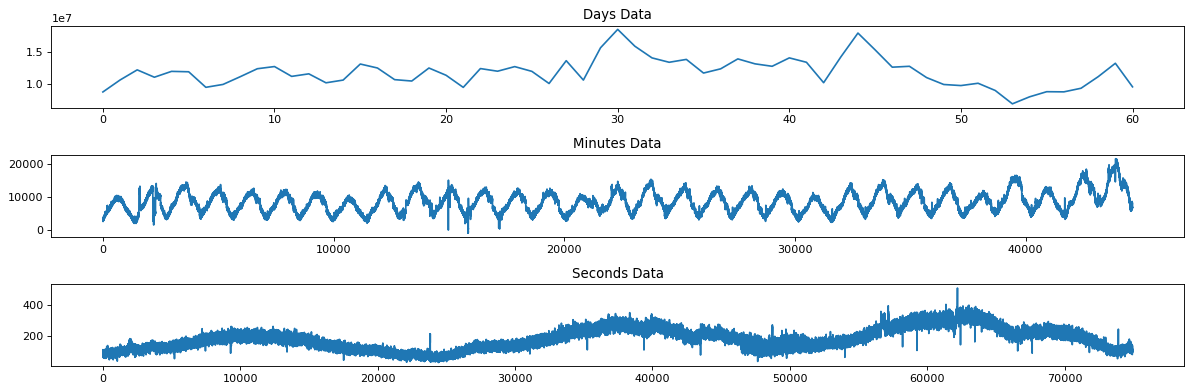

In [4]:
pyplot.figure(figsize=(15,5), dpi=80)

pyplot.subplot(3, 1, 1)
pyplot.plot(values_d[:, 0])
pyplot.title("Days Data")
pyplot.subplot(3, 1, 2)
pyplot.plot(values_m[:, 0])
pyplot.title("Minutes Data")
pyplot.subplot(3, 1, 3)
pyplot.plot(values_s[:, 0])
pyplot.title("Seconds Data")

pyplot.tight_layout()

pyplot.show()

## Generate Minute Data

In [5]:
# Keep getting data from our df_m (minute) data in a circular way
# This allows us to generate data and keep repeating until we run out of days in our dataset
def get_circular_data():
    circular_list = cycle(df_m["count"].values)
    return circular_list

def generate_data(start, end, step, my_func):
    dt_first_timestamp_in_sec = int(start.timestamp())
    dt_first_timestamp_in_sec

    result = []
    while start < end:
        timestamp = start.strftime('%Y-%m-%d %H:%M:%S')
        result.append({"timestamp":timestamp,
                       "value": next(my_func)
                      })
        start += step
    return result

In [6]:
# Generate some data from Feb 1st 2019 to Feb 5th 2019
start = datetime.datetime(2019, 2, 1)
end = datetime.datetime(2019, 5, 5, 23, 59, 59)
step = datetime.timedelta(minutes=1) # By minutes (because we're using our minute dataset)

df = pd.DataFrame(generate_data(start,end,step,get_circular_data()))

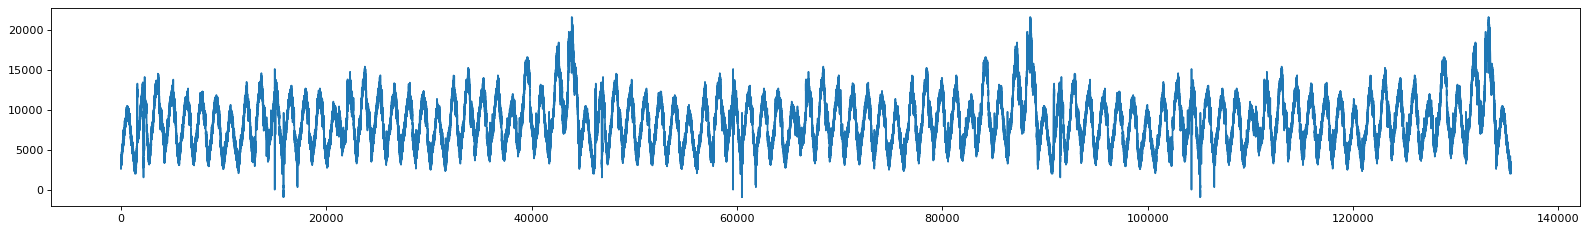

In [7]:
pyplot.figure(figsize=(20,3), dpi=80)
pyplot.plot(df["value"])
pyplot.tight_layout()
pyplot.show()

## Randomly Generating Other Columns

In [8]:
# Latency is loosely related to traffic volume
#  Although good systems don't see an increase in latency when the traffic increases
def latency(value):
    latency = 500 # 100 ms is the default
    
    if value > 9000:
        latency = latency * (1.01+random.uniform(0, 1))
    if value > 11000:
        latency = latency * (1.09+random.uniform(0, 1))
    if value < 5000:
        latency = latency * (0.7+random.uniform(0, 1))
    
    return latency
    
# We don't want to see many database errors, so let's simulate rare occurences
def db_errors(value, host_num):
    if host_num == 1:
        1 if random.randint(0,100000) > 77777 else np.NaN
    if host_num == 2:
        1 if random.randint(0,100000) > 99998 else np.NaN
    if host_num == 3:
        1 if random.randint(0,1000000) > 999999 else np.NaN
    
    return 1 if random.randint(0,100) > 99 else np.NaN

In [9]:
df["http_500"] = df["value"]*.05 # Server Error
df["http_404"] = df["value"]*.1 # Page not found
df["http_200"] = df["value"]*5 # OK

df["login_success"] = df["value"]*.6
df["latency"] = df["value"].apply(lambda x: latency(x))


df["db_errors_host01"] = df["value"].apply(lambda x: db_errors(x,1))
df["db_errors_host02"] = df["value"].apply(lambda x: db_errors(x,2))
df["db_errors_host03"] = df["value"].apply(lambda x: db_errors(x,3))

## Plots

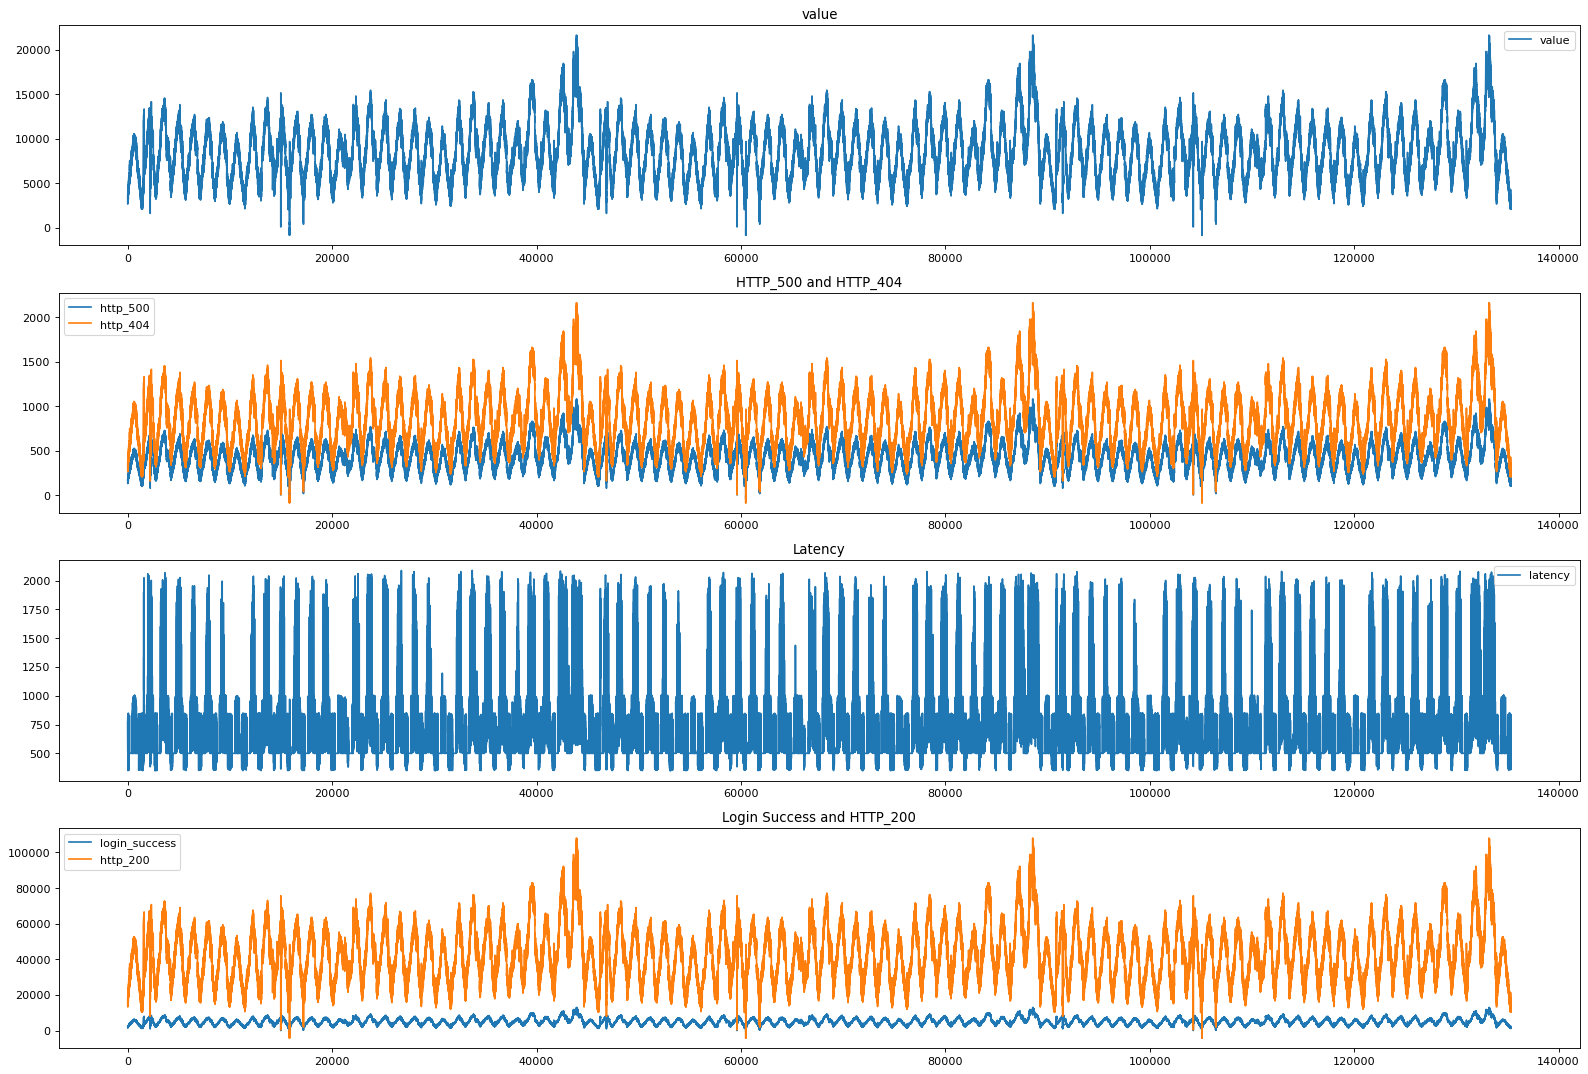

In [10]:
pyplot.figure(figsize=(20,20), dpi=80)
# plot each column
pyplot.subplot(6, 1, 1)
pyplot.plot(df["value"], label="value")
pyplot.title("value")
pyplot.legend()
pyplot.subplot(6, 1, 2)
pyplot.plot(df["http_500"], label="http_500")
pyplot.plot(df["http_404"], label="http_404")
pyplot.title("HTTP_500 and HTTP_404")
pyplot.legend()
pyplot.subplot(6, 1, 3)
pyplot.plot(df["latency"], label="latency")
pyplot.title("Latency")
pyplot.legend()
pyplot.subplot(6, 1, 4)
pyplot.plot(df["login_success"], label="login_success")
pyplot.plot(df["http_200"], label="http_200")
pyplot.title("Login Success and HTTP_200")
pyplot.legend()

pyplot.tight_layout()
pyplot.show()

# LSTM Application

## Function For Converting Time Series Data for Supervised Learning

In [11]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Preparing Data

In [12]:
df = df.set_index('timestamp')
df.head()

,value,http_500,http_404,http_200,login_success,latency,db_errors_host01,db_errors_host02,db_errors_host03
timestamp,,,,,,,,,
2019-02-01 00:00:00,3659,182.95,365.9,18295,2195.4,773.313982,NaN,NaN,NaN
2019-02-01 00:01:00,3465,173.25,346.5,17325,2079.0,639.220864,NaN,NaN,NaN
2019-02-01 00:02:00,3159,157.95,315.9,15795,1895.4,556.640186,NaN,NaN,NaN
2019-02-01 00:03:00,3128,156.40,312.8,15640,1876.8,525.873116,NaN,NaN,NaN
2019-02-01 00:04:00,3544,177.20,354.4,17720,2126.4,525.711490,NaN,NaN,NaN


In [13]:
# Replace Null values with 0's
df['db_errors_host01'].fillna(0, inplace=True)
df['db_errors_host02'].fillna(0, inplace=True)
df['db_errors_host03'].fillna(0, inplace=True)
df.head()

,value,http_500,http_404,http_200,login_success,latency,db_errors_host01,db_errors_host02,db_errors_host03
timestamp,,,,,,,,,
2019-02-01 00:00:00,3659,182.95,365.9,18295,2195.4,773.313982,0.0,0.0,0.0
2019-02-01 00:01:00,3465,173.25,346.5,17325,2079.0,639.220864,0.0,0.0,0.0
2019-02-01 00:02:00,3159,157.95,315.9,15795,1895.4,556.640186,0.0,0.0,0.0
2019-02-01 00:03:00,3128,156.40,312.8,15640,1876.8,525.873116,0.0,0.0,0.0
2019-02-01 00:04:00,3544,177.20,354.4,17720,2126.4,525.711490,0.0,0.0,0.0


In [14]:
values = df.values

In [16]:
from sklearn.preprocessing import MinMaxScaler
# integer encoding of labels (not using yet here)
#encoder = LabelEncoder()
#values[:,1] = encoder.fit_transform(values[:,1])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
reframed.drop(reframed.columns[[10, 11, 12, 13, 14, 15, 16, 17]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
1,0.200855,0.200855,0.200855,0.200855,0.200855,0.243613,0.0,0.0,0.0,0.192219
2,0.192219,0.192219,0.192219,0.192219,0.192219,0.166441,0.0,0.0,0.0,0.178597
3,0.178597,0.178597,0.178597,0.178597,0.178597,0.118915,0.0,0.0,0.0,0.177217
4,0.177217,0.177217,0.177217,0.177217,0.177217,0.101208,0.0,0.0,0.0,0.195735
5,0.195735,0.195735,0.195735,0.195735,0.195735,0.101115,0.0,0.0,0.0,0.189770


In [17]:
# split into train, test, and prediction sets
values = reframed.values
n_predict = floor((len(values) * 0.10))
#n_predict = floor(365/4)
n_train = floor((len(values) * 0.80))
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :]
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(108287, 1, 9) (108287,) (13537, 1, 9) (13537,) (13535, 1, 9) (13535,)


## Running LSTM

In [22]:
# design network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
#model.add(LSTM(100, dropout=0.5, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(
    loss='mae',
    optimizer='adam',
    metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                12000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
1504/1504 - 4s - loss: 0.0258 - root_mean_squared_error: 0.0467 - val_loss: 0.0214 - val_root_mean_squared_error: 0.0267
Epoch 2/50
1504/1504 - 2s - loss: 0.0195 - root_mean_squared_error: 0.0250 - val_loss: 0.0183 - val_root_mean_squared_error: 0.0230
Epoch 3/50
1504/1504 - 2s - loss: 0.0193 - root_mean_squared_error: 0.0249 - val_loss: 0.0177 - val_root_mean_squared_error: 0.0221
Epoch 4/50
1504/1504 - 2s - loss: 0.0192 - root_mean_squared_error: 0.0248 - val_loss: 0.0176 - val_root_mean_squared_error: 0.0220
Epoch 5/50
1504/1504 - 2s - loss: 0.0191 - root_mean_squared_error: 0.0247 - val_loss: 0.0176 - val_root_mean_squared_error: 0.0220
Epoch 6/50
1504/1504 - 2s - loss: 0.0190 - root_mean_squared_error: 0.0246 - val_loss: 0.0175 - val_root_mean_squared_error: 0.0219
Epoch 7/50
1504/1504 - 2s - loss: 0.0189 - root_mean_squared_error: 0.0244 - val_loss: 0.0176 - val_root_mean_squared_error: 0.0220
Epoch 8/50
1504/1504 - 2s - loss: 0.0188 - root_mean_squared_error: 0.0243 -

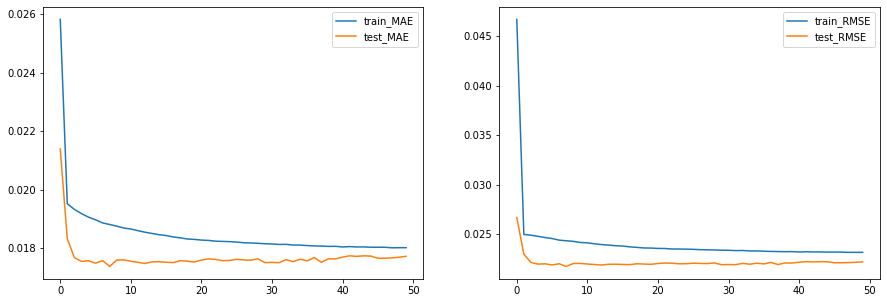

In [23]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(15,5))
pyplot.subplot(1, 2, 1)
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.legend()
pyplot.subplot(1, 2, 2)
pyplot.plot(history.history['root_mean_squared_error'], label='train_RMSE')
pyplot.plot(history.history['val_root_mean_squared_error'], label='test_RMSE')
pyplot.legend()
pyplot.show()

In [24]:
# make a prediction
yhat = model.predict(predict_X)
predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [25]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 556.382
Normalized RMSE: 0.028


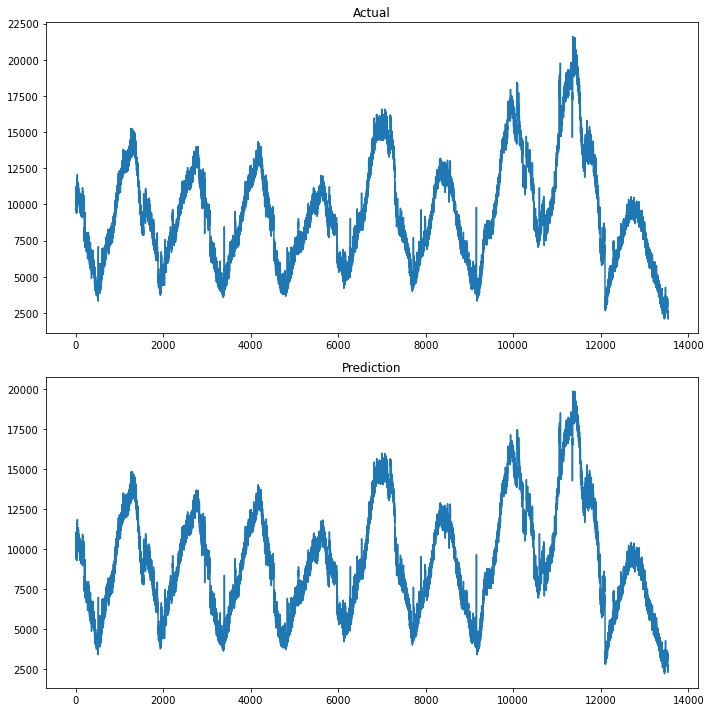

In [26]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(10,10))
pyplot.subplot(2, 1, 1)
pyplot.plot(inv_y, label="Actual")
pyplot.title("Actual")
pyplot.subplot(2, 1, 2)
pyplot.plot(inv_yhat, label="Prediction")
pyplot.title("Prediction")
pyplot.tight_layout()
pyplot.show()

In [27]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
shap_values_2D = shap_values[0].reshape(-1,9)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


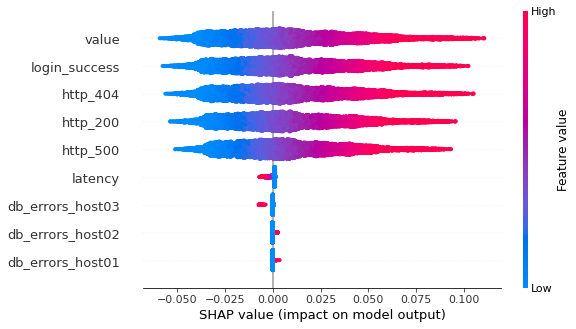

In [28]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=df.columns)